In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [24]:
df = pd.read_csv('Air pollution dataset.csv')
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72275 entries, 0 to 72274
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        72275 non-null  object 
 1   Date        72275 non-null  object 
 2   PM2.5       61189 non-null  float64
 3   PM10        53359 non-null  float64
 4   NO          62341 non-null  float64
 5   NO2         62312 non-null  float64
 6   NOx         60301 non-null  float64
 7   NH3         54210 non-null  float64
 8   CO          63845 non-null  float64
 9   SO2         61989 non-null  float64
 10  O3          60537 non-null  float64
 11  Benzene     54670 non-null  float64
 12  Toluene     50820 non-null  float64
 13  Xylene      28197 non-null  float64
 14  AQI         61077 non-null  float64
 15  AQI_Bucket  61077 non-null  object 
dtypes: float64(13), object(3)
memory usage: 8.8+ MB


In [26]:
null_percent = df.isnull().mean() * 100
print("\n Null Percentage per Column:")
print(null_percent[null_percent > 0].sort_values(ascending=False))


 Null Percentage per Column:
Xylene        60.986510
Toluene       29.685230
PM10          26.172259
NH3           24.994811
Benzene       24.358354
NOx           16.567278
O3            16.240747
AQI           15.493601
AQI_Bucket    15.493601
PM2.5         15.338637
SO2           14.231754
NO2           13.784850
NO            13.744725
CO            11.663784
dtype: float64


In [27]:
threshold = 50
cols_to_drop = null_percent[null_percent > threshold].index
df = df.drop(columns=cols_to_drop)
print(f"\n Dropped columns with more than {threshold}% null values: {list(cols_to_drop)}")


 Dropped columns with more than 50% null values: ['Xylene']


In [28]:
aqi_column = df['AQI'].copy()
# Step 4: Fill all numeric columns (except AQI) with median
df = df.drop(columns=['AQI'])
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

In [29]:
# Step 5: Add AQI column back with original nulls
df['AQI'] = aqi_column

# Step 6: Drop AQI_Bucket if exists (will be regenerated later)
df.drop(columns=['AQI_Bucket'], errors='ignore', inplace=True)

In [30]:
# Step 7: Regression to predict missing AQI values
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']

# Ensure only rows with complete feature data are used
df_aqi_missing = df[df['AQI'].isnull()]
df_aqi_missing = df_aqi_missing.dropna(subset=features)

df_aqi_present = df[df['AQI'].notnull()]

X_train = df_aqi_present[features]
y_train = df_aqi_present['AQI']

reg = LinearRegression()
reg.fit(X_train, y_train)

X_missing = df_aqi_missing[features]
predicted_aqi = reg.predict(X_missing)

# Step 8: Fill back predicted AQI
df.loc[X_missing.index, 'AQI'] = predicted_aqi

# Step 9: Confirm final nulls
print("\n Final null counts:")
print(df.isnull().sum())


 Final null counts:
City       0
Date       0
PM2.5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
AQI        0
dtype: int64


In [31]:
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
0,Ahmedabad,2015-01-01,47.187951,92.407096,0.92,18.22,17.15,15.684667,0.92,27.64,133.36,0.00,0.02,164.945461
1,Ahmedabad,2015-01-02,47.187951,92.407096,0.97,15.69,16.46,15.684667,0.97,24.55,34.06,3.68,5.50,133.172681
2,Ahmedabad,2015-01-03,47.187951,92.407096,17.40,19.30,29.70,15.684667,17.40,29.07,30.70,6.80,16.40,278.070782
3,Ahmedabad,2015-01-04,47.187951,92.407096,1.70,18.48,17.97,15.684667,1.70,18.59,36.08,4.43,10.14,135.220923
4,Ahmedabad,2015-01-05,47.187951,92.407096,22.10,21.42,37.76,15.684667,22.10,39.33,39.31,7.01,18.89,334.298548


In [32]:
# Step: Define a function to classify AQI
def classify_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

# Step: Apply the function to create a new column
df['AQI_Bucket'] = df['AQI'].apply(classify_aqi)

# Preview value counts
print("\n AQI Category Distribution:")
print(df['AQI_Bucket'].value_counts())



 AQI Category Distribution:
AQI_Bucket
Moderate        30354
Satisfactory    19782
Poor             7980
Good             7037
Very Poor        4320
Severe           2802
Name: count, dtype: int64


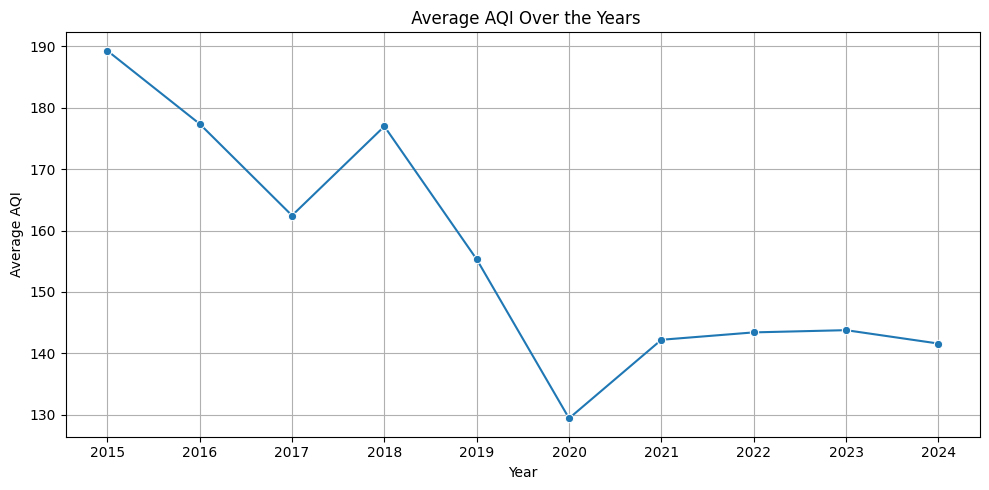

In [33]:
# Ensure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract year
df['Year'] = df['Date'].dt.year

# Group by year and calculate average AQI
yearly_avg_aqi = df.groupby('Year')['AQI'].mean().reset_index()

# Plot with all years on x-axis
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_avg_aqi, x='Year', y='AQI', marker='o')
plt.title(' Average AQI Over the Years')
plt.xlabel('Year')
plt.ylabel('Average AQI')
plt.xticks(yearly_avg_aqi['Year'])  # 👈 Force all years on x-axis
plt.grid(True)
plt.tight_layout()
plt.show()

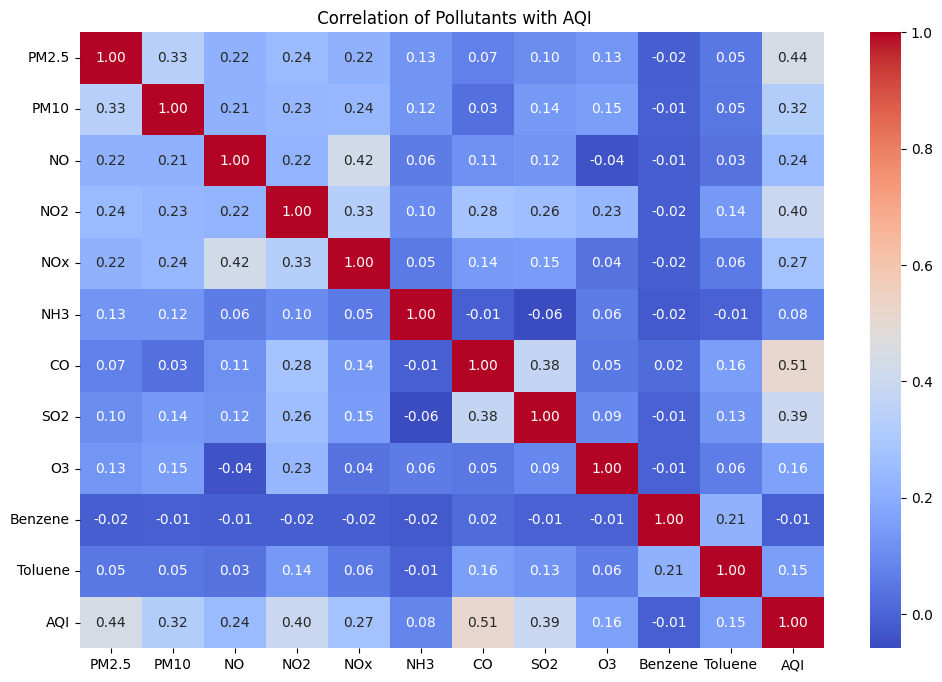

In [34]:
import seaborn as sns
plt.figure(figsize=(12,8))

# Compute correlation matrix
correlation_matrix = df[features + ['AQI']].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(' Correlation of Pollutants with AQI')
plt.show()

In [35]:
# Step 1: Define features (X) and target (y)
X = df.drop(columns=['Date', 'City', 'AQI_Bucket', 'Year'])  # Use only numeric pollutant columns
y = df['AQI_Bucket']  # Target variable

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
# Initialize and train
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
print("🔍 Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))


🔍 Logistic Regression Evaluation:
Accuracy: 0.9260
F1 Score: 0.9238
Classification Report:
              precision    recall  f1-score   support

        Good       0.99      0.95      0.97      1407
    Moderate       0.90      0.98      0.94      6071
        Poor       0.88      0.69      0.77      1596
Satisfactory       0.97      0.96      0.97      3957
      Severe       0.95      0.74      0.83       560
   Very Poor       0.84      0.91      0.87       864

    accuracy                           0.93     14455
   macro avg       0.92      0.87      0.89     14455
weighted avg       0.93      0.93      0.92     14455



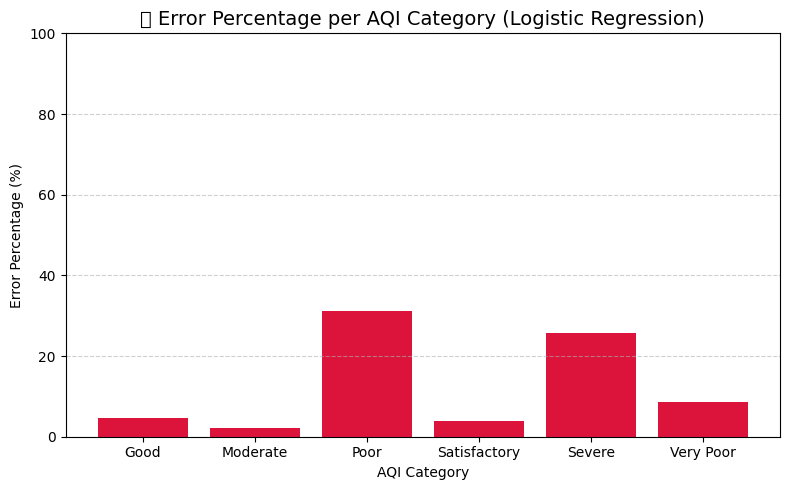

In [36]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Error Percentage Calculation
total_per_class = cm.sum(axis=1)
incorrect_per_class = total_per_class - np.diag(cm)
error_percentage = (incorrect_per_class / total_per_class) * 100

# Plotting Error Percentage
plt.figure(figsize=(8, 5))
aqi_labels = label_encoder.classes_
plt.bar(aqi_labels, error_percentage, color='crimson')
plt.title("🔍 Error Percentage per AQI Category (Logistic Regression)", fontsize=14)
plt.xlabel("AQI Category")
plt.ylabel("Error Percentage (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [37]:
# 4. Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. Predictions
y_pred = rf.predict(X_test)

# 6. Evaluation
print(" Accuracy:", accuracy_score(y_test, y_pred))
print(" F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

 Accuracy: 0.9995849187132481
 F1 Score: 0.9995848248794357

Classification Report:
               precision    recall  f1-score   support

        Good       1.00      1.00      1.00      1407
    Moderate       1.00      1.00      1.00      6071
        Poor       1.00      1.00      1.00      1596
Satisfactory       1.00      1.00      1.00      3957
      Severe       1.00      1.00      1.00       560
   Very Poor       1.00      1.00      1.00       864

    accuracy                           1.00     14455
   macro avg       1.00      1.00      1.00     14455
weighted avg       1.00      1.00      1.00     14455



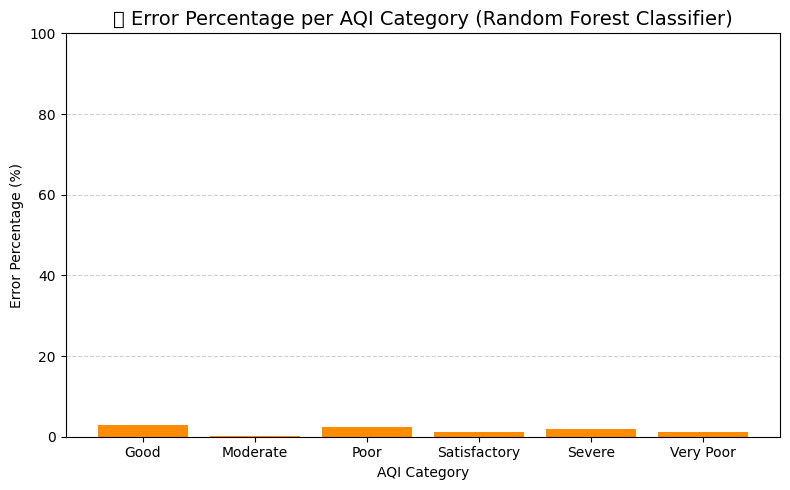

In [41]:
cm_rf = confusion_matrix(y_test, y_pred)

# Error Percentage Calculation
total_per_class_rf = cm_rf.sum(axis=1)
incorrect_per_class_rf = total_per_class_rf - np.diag(cm_rf)
error_percentage_rf = (incorrect_per_class_rf / total_per_class_rf) * 100

# Plotting Error Percentage
plt.figure(figsize=(8, 5))
plt.bar(label_encoder.classes_, error_percentage_rf, color='darkorange')
plt.title("🔍 Error Percentage per AQI Category (Random Forest Classifier)", fontsize=14)
plt.xlabel("AQI Category")
plt.ylabel("Error Percentage (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [39]:
# Initialize and train SVM
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

# Predict
y_pred = svm.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9885852646143203
F1 Score: 0.9885692171359107

Classification Report:
               precision    recall  f1-score   support

        Good       0.99      0.97      0.98      1407
    Moderate       0.99      1.00      0.99      6071
        Poor       0.99      0.97      0.98      1596
Satisfactory       0.99      0.99      0.99      3957
      Severe       1.00      0.98      0.99       560
   Very Poor       0.97      0.99      0.98       864

    accuracy                           0.99     14455
   macro avg       0.99      0.98      0.99     14455
weighted avg       0.99      0.99      0.99     14455



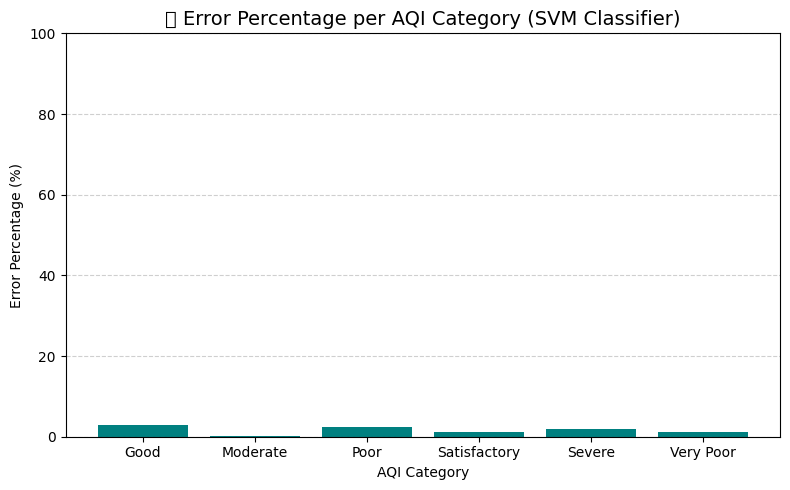

In [42]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred)

# Error Percentage Calculation
total_per_class_svm = cm_svm.sum(axis=1)
incorrect_per_class_svm = total_per_class_svm - np.diag(cm_svm)
error_percentage_svm = (incorrect_per_class_svm / total_per_class_svm) * 100

# Plotting Error Percentage
plt.figure(figsize=(8, 5))
plt.bar(label_encoder.classes_, error_percentage_svm, color='teal')
plt.title("🔍 Error Percentage per AQI Category (SVM Classifier)", fontsize=14)
plt.xlabel("AQI Category")
plt.ylabel("Error Percentage (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()